# Project Extension: User Movement in Location-Based Social Networks in Megalopolises

In this project extension, we are going to be focusing on the dataset containing location-based social networks of two densely populated cities: New York City and Tokyo.  Will be trying to answer similar questions as those explored in the article "Friendship and Mobility: User Movement in Location-Based Social Network".

Here is the pipeline which was undertaken during our data exploration:
1. Loading and Pre-processing the data
2. Identifying User's Homes: A Change of Scale
3. Distribution of User's Check-ins as a function of distance traveled: Do users restrict themselves to their neighborhoods, or do travel further away ?
4. Is there a clear work/home routine? What are these New Yorker's and Tokyoite's habits?
5. What type of activities are the most popular, when and where are they done? Are different types of venues geographically close or spread out?
6. Are these trends comparable between megalopolises?

Link to dataset: https://sites.google.com/site/yangdingqi/home/foursquare-dataset

In order to have a reference for interpretation (naming boroughs and hallmarks), here are two maps of New York City and Tokyo

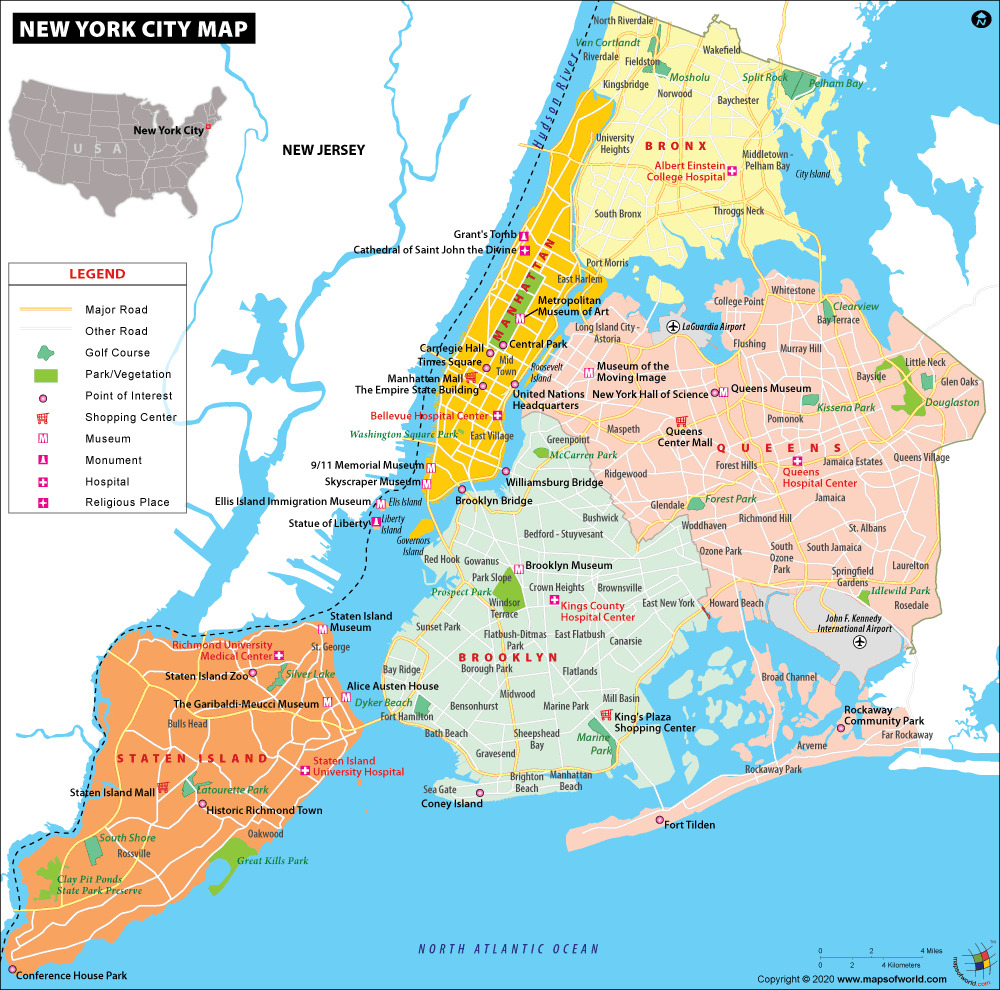

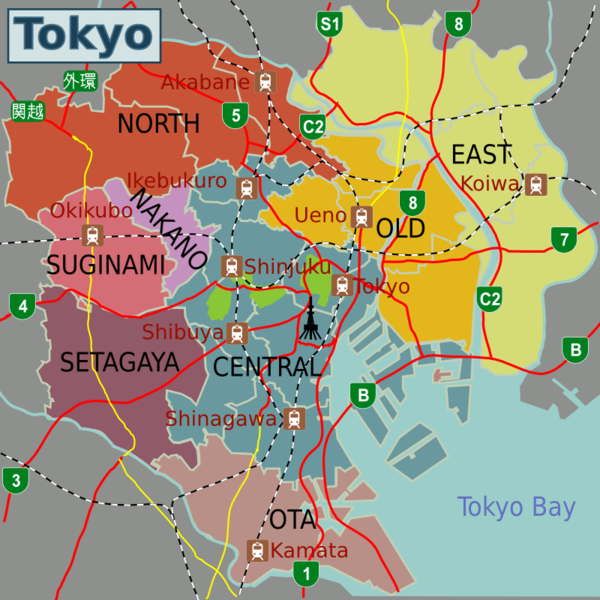


###### Importing the libraries needed for this project:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

# For visualizing long/lat data
import folium  
from folium import plugins
import branca.colormap # In order to use heatmaps on folium maps
from collections import defaultdict # Also used when creating coloar bar
import geopandas as gpd 
from keplergl import KeplerGl

# For trying NLP
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim
from gensim import corpora, models
import en_core_web_sm
nlp = en_core_web_sm.load()


import os, codecs, string, random
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle

seed = 42
random.seed(seed)
np.random.seed(seed)

# Part 1: Loading and Pre-processing the Data

### <ins>Step 1</ins>: Loading the data

In [2]:
# Path
#DATA_FOLDER = '/Users/louiseplacidet/Desktop/ADA/Project/Extension/Data/'
DATA_FOLDER = './Data/'
NYC = DATA_FOLDER+'dataset_TSMC2014_NYC.txt'
TKY = DATA_FOLDER+'dataset_TSMC2014_TKY.txt'

# Loading data
nyc = pd.read_csv(NYC, header = None, sep='\t', engine='python',
                  names=['user_ID', 'venue_ID', 'venue_category_ID','venue_category_name',
                         'latitude', 'longitude', 'offset', 'UTC_time'])
tky = pd.read_csv(TKY, header = None, sep='\t', engine='python',
                  names=['user_ID', 'venue_ID', 'venue_category_ID','venue_category_name',
                         'latitude', 'longitude', 'offset', 'UTC_time'])

In [3]:
display(nyc.head(3))
display(tky.head(3))

,user_ID,venue_ID,venue_category_ID,venue_category_name,latitude,longitude,offset,UTC_time
0,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,Tue Apr 03 18:00:09 +0000 2012
1,979,4a43c0aef964a520c6a61fe3,4bf58dd8d48988d1df941735,Bridge,40.606800,-74.044170,-240,Tue Apr 03 18:00:25 +0000 2012
2,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,Home (private),40.716162,-73.883070,-240,Tue Apr 03 18:02:24 +0000 2012


,user_ID,venue_ID,venue_category_ID,venue_category_name,latitude,longitude,offset,UTC_time
0,1541,4f0fd5a8e4b03856eeb6c8cb,4bf58dd8d48988d10c951735,Cosmetics Shop,35.705101,139.619590,540,Tue Apr 03 18:17:18 +0000 2012
1,868,4b7b884ff964a5207d662fe3,4bf58dd8d48988d1d1941735,Ramen / Noodle House,35.715581,139.800317,540,Tue Apr 03 18:22:04 +0000 2012
2,114,4c16fdda96040f477cc473a5,4d954b0ea243a5684a65b473,Convenience Store,35.714542,139.480065,540,Tue Apr 03 19:12:07 +0000 2012


In the two dataframes above, we are given additional information compared the dataframe in the replication project. Namely, we are given the "venue_category_name", which will enable us to draw more information about the habits of these New Yorkers and Tokyoites.

### <ins>Step 2</ins>: Pre-Processing the Data

###  1. Converting longitude and latitude into km values, and creating a grid

Similar to the Friendship and Mobility paper, we are estimating the home location of a user based on their check-in locations. This is accomplished by dividing our two cities into a grid, of size N by N km. N is the length of one unit in the grid and can be considered to be a design parameter. Indeed, we cannot use 25 km as we had previously done in the replication paper, given that we are working with a much denser dataset.

This is done by using the following conversions:

Latitude 1°: 110.574 km  
Longtiude: 1°: 111.320*cos(latitude) km

In [4]:
# The grid cells are discrete so we are rounding to the closest cell

def lat2km(lat, N):
    # Convert a latitude value to a N km grid
    km = np.round((110.574*lat)/N)
    return km
    
def long2km(long, lat, N):
    # Convert a longitude value to a N km grid 
    km = np.round((110.320 * long * np.cos(np.deg2rad(lat)))/N)
    return km
                  

In [5]:
N = 0.5
nyc['x_grid'] = long2km(nyc.longitude, nyc.latitude, N)
nyc['y_grid'] = lat2km(nyc.latitude, N)

tky['x_grid'] = long2km(tky.longitude, tky.latitude, N)
tky['y_grid'] = lat2km(tky.latitude, N)

In [6]:
# Calculate distance between two pairs of long/lat coordinates. 
# Solution from: https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas/29546836#29546836

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km


### 2 . Getting the Local Time:

The time in the dataframe is the UTC time.  In order to compare the time that the activities were done in either New York or Tokyo, we need to convert the times into local times

In [7]:
def format_datetime(dt_series):

    def get_split_date(strdt):
        split_date = strdt.split()
        str_date = split_date[1] + ' ' + split_date[2] + ' ' + split_date[5] + ' ' + split_date[3]
        return str_date

    dt_series = pd.to_datetime(dt_series.apply(lambda x: get_split_date(x)), format = '%b %d %Y %H:%M:%S')

    return dt_series

In [8]:
nyc.UTC_time = format_datetime(nyc.UTC_time)
tky.UTC_time = format_datetime(tky.UTC_time)

In [9]:
nyc['local_time'] = nyc.apply(lambda x: x.UTC_time + dt.timedelta(minutes = x.offset), axis=1)
tky['local_time'] = tky.apply(lambda x: x.UTC_time + dt.timedelta(minutes = x.offset), axis=1)

In [10]:
nyc.head()

,user_ID,venue_ID,venue_category_ID,venue_category_name,latitude,longitude,offset,UTC_time,x_grid,y_grid,local_time
0,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,2012-04-03 18:00:09,-12375.0,9005.0,2012-04-03 14:00:09
1,979,4a43c0aef964a520c6a61fe3,4bf58dd8d48988d1df941735,Bridge,40.606800,-74.044170,-240,2012-04-03 18:00:25,-12403.0,8980.0,2012-04-03 14:00:25
2,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,Home (private),40.716162,-73.883070,-240,2012-04-03 18:02:24,-12356.0,9004.0,2012-04-03 14:02:24
3,395,4bc7086715a7ef3bef9878da,4bf58dd8d48988d104941735,Medical Center,40.745164,-73.982519,-240,2012-04-03 18:02:41,-12367.0,9011.0,2012-04-03 14:02:41
4,87,4cf2c5321d18a143951b5cec,4bf58dd8d48988d1cb941735,Food Truck,40.740104,-73.989658,-240,2012-04-03 18:03:00,-12369.0,9010.0,2012-04-03 14:03:00


# Part 2: Identifying User's Homes: A Change of Scale

### <ins>Step 1</ins>: Identifying User's home using FourSquare Data and by inferring

In the FourSquare Data, some of the check-ins are labeled as the user's home.  However, not all users have check-ins corresponding to their homes (for instance, it is not the case for user 1).  As a result, the method used in the replication paper will also be applied to estimate the home locations for users who do not have check-ins labeled as "Home (private)".

Moreover, for the users who do have such check-ins, it is interesting to compare the coordinates of that check-in to the approximation we can make using the method described in the replication paper.  This will enable us to get a feel for the accuracy of our computation!

###### 1. The User's Homes According to FourSquare :

As stated above, some of the users don't have check-ins corresponding to their homes, as it is the case for user 1:

In [11]:
nyc[(nyc["user_ID"]==1)&(nyc["venue_category_name"]=="Home (private)")]

,user_ID,venue_ID,venue_category_ID,venue_category_name,latitude,longitude,offset,UTC_time,x_grid,y_grid,local_time


Moreover, in the table below, we can see that the users who do have check-ins corresponding to their homes, can have more than one check-in.  When comparing their latitude and longitude, they are quite close, and the home location assigned to the user will therefore be considered as the average of those.

In [12]:
# Retrieving all the homes check-ins
four_square_nyc_homes = nyc[nyc['venue_category_name'] == "Home (private)"][["user_ID", "venue_category_name", "latitude", "longitude"]] # Creating a dataframe with the home locations for the users
four_square_nyc_homes.set_index(["user_ID"], drop=True, inplace=True)
four_square_nyc_homes.sort_index(axis = 0, inplace = True) #Sorting this dataframe enables us to realize that some users have multiple check-ins related to their homes
display(four_square_nyc_homes.head(3))

four_square_tky_homes = tky[tky['venue_category_name'] == "Home (private)"][["user_ID", "venue_category_name", "latitude", "longitude"]] # Creating a dataframe with the home locations for the users
four_square_tky_homes.set_index(["user_ID"], drop=True, inplace=True)
four_square_tky_homes.sort_index(axis = 0, inplace = True) #Sorting this dataframe enables us to realize that some users have multiple check-ins related to their homes
display(four_square_tky_homes.head(3))

,venue_category_name,latitude,longitude
user_ID,,,
2,Home (private),40.625787,-74.153356
2,Home (private),40.562843,-73.918346
2,Home (private),40.625784,-74.082884


,venue_category_name,latitude,longitude
user_ID,,,
21,Home (private),35.705644,139.849608
21,Home (private),35.705644,139.849608
21,Home (private),35.705644,139.849608


In [13]:
# Taking the average if there are several check-ins for each user

four_square_nyc_homes = four_square_nyc_homes.groupby(by="user_ID")[["latitude","longitude"]].mean()
display(four_square_nyc_homes.head(3))

four_square_tky_homes = four_square_tky_homes.groupby(by="user_ID")[["latitude","longitude"]].mean()
display(four_square_tky_homes.head(3))

,latitude,longitude
user_ID,,
2,40.594314,-74.018233
5,40.728001,-74.035888
6,40.833165,-73.941860


,latitude,longitude
user_ID,,
21,35.705644,139.849608
42,35.584788,139.594220
63,35.668599,139.772672


###### 2. The User's Homes According to the replication paper's approximation technique :

Using the technique described in the replication paper, we consider that the dataframes for the homes have the x and y coordinates for the cell within the grid with the most check-ins.  We then estimate the home position by using the average longitude and latitude for check-ins within this cell for each user.

To accomplish this, we concatenate the x and y coordinates for the grid into a string and then using the mode on that string. This ensures that the mode is being found on a given x-y coordinate pair.

In [14]:
# Concatenate the coordinates into a string to use as the mode
nyc['cord'] = nyc.x_grid.astype(str) + nyc.y_grid.astype(str)
tky['cord'] = tky.x_grid.astype(str) + tky.y_grid.astype(str)

In [15]:
# # The home locations can be obtained by counting the most common x and y cells for each user
# # This is done by storing the mode of each user's check-in cell's x and y coordinates.
nyc_homes = pd.DataFrame()
nyc_homes['mode_cord'] = nyc.groupby(['user_ID'])['cord'].apply(pd.Series.mode)
nyc_homes = nyc_homes.reset_index().drop(['level_1'], axis=1) # get rid of multiindex

tky_homes = pd.DataFrame()
tky_homes['mode_cord'] = tky.groupby(['user_ID'])['cord'].apply(pd.Series.mode)
tky_homes = tky_homes.reset_index().drop(['level_1'], axis=1)

The dataframes for the homes have the x and y coordinates for the cell within the grid with the most check-ins. We estimate the home position by using the average longitude and latitude for check-ins within this cell for each user. 

In [16]:
# Combine the dataframes by merging on multiple columns; this keeps only the check ins in the 'home' cell. 
nyc_homes = pd.merge(nyc_homes, nyc, how = 'left', left_on=['user_ID', 'mode_cord'], right_on =['user_ID', 'cord'])

# Obtain the mean longitude and latitude for the estimated home location
nyc_homes = nyc_homes.groupby('user_ID')[['longitude', 'latitude']].mean()

tky_homes = pd.merge(tky_homes, tky, how = 'left', left_on=['user_ID', 'mode_cord'], right_on =['user_ID', 'cord'])
tky_homes = tky_homes.groupby('user_ID')[['longitude', 'latitude']].mean()

In [17]:
display(nyc_homes.head(3))
display(tky_homes.head(3))

,longitude,latitude
user_ID,,
1,-74.004165,40.719994
2,-73.913707,40.646648
3,-73.988551,40.745732


,longitude,latitude
user_ID,,
1,139.773418,35.698775
2,139.698197,35.658062
3,139.600839,35.668477


###### 3. Checking Out the Accuracy of our Predictions :

Now that we have an approximation of all the user's homes using the approximation technique of the article, let's see if this estimation is close to the home check-ins provided by the FourSquare. If that is the case, than we can associate to the users who don't have FourSquare home check-ins our approximation with a correct accuracy.

In [18]:
comparing_homes_nyc = pd.merge(four_square_nyc_homes, nyc_homes, how='left', left_on=['user_ID'], right_on=['user_ID'],suffixes=["_foursquare","_approx"])
comparing_homes_nyc['latitude_pdiff'] =  100*(comparing_homes_nyc['latitude_foursquare'] - comparing_homes_nyc['latitude_approx'])/comparing_homes_nyc['latitude_foursquare']
comparing_homes_nyc['longitude_pdiff'] = 100* (comparing_homes_nyc['longitude_foursquare'] - comparing_homes_nyc['longitude_approx'])/comparing_homes_nyc['longitude_foursquare']
display(comparing_homes_nyc.sample(3))


comparing_homes_tky = pd.merge(four_square_tky_homes, tky_homes, how='left', left_on=['user_ID'], right_on=['user_ID'],suffixes=["_foursquare","_approx"])
comparing_homes_tky['latitude_pdiff'] = 100*(comparing_homes_tky['latitude_foursquare'] - comparing_homes_tky['latitude_approx'])/comparing_homes_tky['latitude_foursquare']
comparing_homes_tky['longitude_pdiff'] = 100*(comparing_homes_tky['longitude_foursquare'] - comparing_homes_tky['longitude_approx'])/comparing_homes_tky['longitude_foursquare']
display(comparing_homes_tky.sample(3))


,latitude_foursquare,longitude_foursquare,longitude_approx,latitude_approx,latitude_pdiff,longitude_pdiff
user_ID,,,,,,
965,40.735450,-73.899869,-73.891605,40.678289,0.140322,0.011182
546,40.723382,-73.813511,-73.912216,40.753636,-0.074292,-0.133722
950,40.807891,-74.059387,-74.037687,40.766551,0.101304,0.029302


,latitude_foursquare,longitude_foursquare,longitude_approx,latitude_approx,latitude_pdiff,longitude_pdiff
user_ID,,,,,,
1622,35.704528,139.777988,139.777957,35.704187,0.000957,0.000022
1344,35.707126,139.734339,139.723382,35.626476,0.225864,0.007842
990,35.775773,139.726884,139.720773,35.778230,-0.006869,0.004374


In [19]:
def bootstrap_CI(data, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)

    return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]

In [20]:
# Get bootstrapped confidence intervals for the mean percentage difference between our approximated home long/lat coordinates
mean_lat_nyc = bootstrap_CI(comparing_homes_nyc.latitude_pdiff, 1000)
mean_long_nyc = bootstrap_CI(comparing_homes_nyc.longitude_pdiff, 1000)

mean_lat_tky = bootstrap_CI(comparing_homes_tky.latitude_pdiff, 1000)
mean_long_tky = bootstrap_CI(comparing_homes_tky.longitude_pdiff, 1000)

#print('Longitudinal split R^2 = {:.4}'.format(r2_score(y_longitudinal_test, y_predict_longitude)))  # returns R^2
print('New York City mean % difference for latitude is: {:.3}%. CI: [{:.3}%, {:.3}%]'.format(comparing_homes_nyc.latitude_pdiff.mean(), mean_lat_nyc[0], mean_lat_nyc[1]))
print('New York City mean % difference for longitude is: {:.3}%. CI: [{:.3}%, {:.3}%]'.format(comparing_homes_nyc.longitude_pdiff.mean(), mean_long_nyc[0], mean_long_nyc[1]))
print('Tokyo mean % difference for latitude is: {:.3}%. CI: [{:.3}%, {:.3}%]'.format(comparing_homes_tky.latitude_pdiff.mean(), mean_lat_tky[0], mean_lat_tky[1]))
print('Tokyo mean % difference for longtitude is: {:.3}%. CI: [{:.3}%, {:.3}%]'.format(comparing_homes_tky.longitude_pdiff.mean(), mean_long_tky[0], mean_long_tky[1]))

New York City mean % difference for latitude is: 0.00459%. CI: [-0.00501%, 0.0139%]
New York City mean % difference for longitude is: -0.0109%. CI: [-0.0166%, -0.00453%]
Tokyo mean % difference for latitude is: 0.0107%. CI: [-0.00572%, 0.0269%]
Tokyo mean % difference for longtitude is: -0.00633%. CI: [-0.0136%, 0.00037%]


Our mean % difference between our prediction and the actual home estimation method. Considering the bootstrapped confidence intervals, the largest % difference is under 0.03%. We can say that our prediction method provides accurate results and can safely infer the homes of user's who do not have a check-in "Home (private)".

###### 4. Computing the final DataFrame containing the user's homes:

To construct the DataFrame containing the user's homes, we will use the home locations from FourSquare if they are provided.  In the absence of home check-ins, we will approximate as done in the replication paper:

In [21]:
# Merging the dataframe so that all users are present, and we associated to them their coordinates provided by foursquare (nan if there are none), and the approximated ones
final_nyc_homes = pd.merge(four_square_nyc_homes, nyc_homes, how='right', left_on=['user_ID'], right_on=['user_ID'], suffixes=['_foursquare','_approx'])

#Setting the coordinates to the foursquare values if they are provided, else tot the infered values
final_nyc_homes['latitude'] = np.where(np.isnan(final_nyc_homes['latitude_foursquare']), final_nyc_homes['latitude_approx'], final_nyc_homes['latitude_foursquare'])
final_nyc_homes['longitude'] = np.where(np.isnan(final_nyc_homes['longitude_foursquare']), final_nyc_homes['longitude_approx'], final_nyc_homes['longitude_foursquare'])
nyc_homes = final_nyc_homes # Renaming into the final dataframe that will be used from now on

# The same is done for Tokyo:
final_tky_homes = pd.merge(four_square_tky_homes, tky_homes, how='right', left_on=['user_ID'], right_on=['user_ID'], suffixes=['_foursquare','_approx'])
final_tky_homes['latitude'] = np.where(np.isnan(final_tky_homes['latitude_foursquare']), final_tky_homes['latitude_approx'], final_tky_homes['latitude_foursquare'])
final_tky_homes['longitude'] = np.where(np.isnan(final_tky_homes['longitude_foursquare']), final_tky_homes['longitude_approx'], final_tky_homes['longitude_foursquare'])
tky_homes = final_tky_homes # Renaming into the final dataframe that will be used from now on


# Renaming columns
nyc_homes = nyc_homes.add_suffix('_home')
tky_homes = tky_homes.add_suffix('_home')

print('For NYC: ')
display(nyc_homes.head(4))
print('For Tokyo: ')
display(tky_homes.head(4))

For NYC: 


,latitude_foursquare_home,longitude_foursquare_home,longitude_approx_home,latitude_approx_home,latitude_home,longitude_home
user_ID,,,,,,
1,NaN,NaN,-74.004165,40.719994,40.719994,-74.004165
2,40.594314,-74.018233,-73.913707,40.646648,40.594314,-74.018233
3,NaN,NaN,-73.988551,40.745732,40.745732,-73.988551
4,NaN,NaN,-73.941512,40.816883,40.816883,-73.941512


For Tokyo: 


,latitude_foursquare_home,longitude_foursquare_home,longitude_approx_home,latitude_approx_home,latitude_home,longitude_home
user_ID,,,,,,
1,NaN,NaN,139.773418,35.698775,35.698775,139.773418
2,NaN,NaN,139.698197,35.658062,35.658062,139.698197
3,NaN,NaN,139.600839,35.668477,35.668477,139.600839
4,NaN,NaN,139.759940,35.665565,35.665565,139.759940


In [22]:
# Dropping the columns in order to only keep final home coordinates

nyc_homes.drop(['latitude_foursquare_home', 'longitude_foursquare_home', 'longitude_approx_home', 'latitude_approx_home'],axis = 1, inplace = True)
tky_homes.drop(['latitude_foursquare_home', 'longitude_foursquare_home', 'longitude_approx_home', 'latitude_approx_home'],axis = 1, inplace = True)

In [23]:
print("Final dataframe of NYC homes: ")
display(nyc_homes.head(5))
print("Final dataframe of Tokyo homes: ")
display(tky_homes.head(5))

Final dataframe of NYC homes: 


,latitude_home,longitude_home
user_ID,,
1,40.719994,-74.004165
2,40.594314,-74.018233
3,40.745732,-73.988551
4,40.816883,-73.941512
5,40.728001,-74.035888


Final dataframe of Tokyo homes: 


,latitude_home,longitude_home
user_ID,,
1,35.698775,139.773418
2,35.658062,139.698197
3,35.668477,139.600839
4,35.665565,139.759940
5,35.699554,139.770995


### <ins>Step 2</ins>: Locating User's homes, are they clustered?


Now that we have associated a home to each user, an interesting question is to see if the are residential areas in NYC and Tokyo.  Are the home clustered together and we can define specific areas? Or are user's homes spread out over the entirety of these dense cities?

###### 1. Getting the mean coordinates of all check-ins for both NYC and Tokyo

In order to plot where the residential areas are located on the heatmap provided by the folium library, we need to compute the average coordinates of all check-ins for both cities respectively.  As a result, we will plug in these mean coordinates and be able to display the map centered on the area we are interested in.

In [24]:
nyc_coordinates = [nyc.latitude.mean(), nyc.longitude.mean()]
tky_coordinates = [tky.latitude.mean(), tky.longitude.mean()]

###### 2. Plotting where the user's homes are located:

Now let's plot the density of user's homes for both New York city and Tokyo:

In [25]:
# In order to insert a color bar, the following stack overflow was used: https://stackoverflow.com/questions/47163728/how-to-add-legend-gradient-in-folium-heat-map

map_nyc = folium.Map(nyc_coordinates, zoom_start=11)

# convert to (n, 2) nd-array format for heatmap
heatmap_locs = nyc_homes[['latitude_home', 'longitude_home']].to_numpy()

steps=50
colormap = branca.colormap.linear.YlOrRd_09.scale(0, 1).to_step(steps)
gradient_map=defaultdict(dict)
for i in range(steps):
    gradient_map[1/steps*i] = colormap.rgb_hex_str(1/steps*i)
colormap.add_to(map_nyc) #add color bar at the top of the map

# # plot heatmap
map_nyc.add_child(plugins.HeatMap(heatmap_locs, gradient = gradient_map, radius=10))

# Add 10 km circle around median home location
folium.Circle([nyc_homes.latitude_home.median(), nyc_homes.longitude_home.median()], radius = 10000).add_to(map_nyc)

print("Heatmap of User's Homes for NYC:")
# (commented out since it does not show up on github)
#map_nyc

Heatmap of User's Homes for NYC:


<img src="Images/nyc_heatmap.png" style="width: 800px;">

In [ ]:
map_tky = folium.Map(tky_coordinates, zoom_start=11)

# convert to (n, 2) nd-array format for heatmap
heatmap_locs = tky_homes[['latitude_home', 'longitude_home']].to_numpy()

steps=50
colormap = branca.colormap.linear.YlOrRd_09.scale(0, 1).to_step(steps)
gradient_map=defaultdict(dict)
for i in range(steps):
    gradient_map[1/steps*i] = colormap.rgb_hex_str(1/steps*i)
colormap.add_to(map_tky) #add color bar at the top of the map

# # plot heatmap
map_tky.add_child(plugins.HeatMap(heatmap_locs, gradient = gradient_map, radius=10))

# Add 10 km circle around median home location
folium.Circle([tky_homes.latitude_home.median(), tky_homes.longitude_home.median()], radius = 10000).add_to(map_tky)
print("Heatmap of User's Homes in Tokyo:")
# (commented out since it does not show up on github)
#map_tky

<img src="Images/tky_heatmap.png" style="width: 800px;">


When looking at the New York heat map, it appears that the user's homes are more evenly distributed over Manhattan, with some users located also in Brooklyn.

In the case of Tokyo, the user's homes are also spread out, with some areas of higher concentration (the "North", Nakano and Suginami, and the "Old" regions).

As a result, we can see in both cases that in densely populated are the residential areas are spread out over the entire cities and not restricted to a certain region.

# Part 3: Distribution of User's Check-ins as a function of distance traveled

Now that we have associated a home to each of the user of this platform, the next interesting step consists in looking at the fraction of check-ins as a function of the distance.

Indeed, we can compare this distribution to the one presented in the replication article (showing a kink at 100 km).  A current hypothesis is that the distribution in cities would be more spread out: given that a city tends to be attractive for its out of habit experience, one could expect that users travel farther from them home to discover new places. Let's see if this hypothesis holds up!

### <ins>Step 1</ins>: Computing distance of check-ins from user's homes

Let's compute the distance of the user's home locations to that of their check-ins

###### 1. Merging homes locations with dataframe containing all of the checkins 

In [27]:
nyc_checkin_homes = nyc.merge(nyc_homes[['latitude_home','longitude_home']], left_on='user_ID', right_index=True)
tky_checkin_homes = tky.merge(tky_homes[['latitude_home','longitude_home']], left_on='user_ID', right_index=True)

display(nyc_checkin_homes.head())
print(nyc.shape, nyc_homes.shape, nyc_checkin_homes.shape)

,user_ID,venue_ID,venue_category_ID,venue_category_name,latitude,longitude,offset,UTC_time,x_grid,y_grid,local_time,cord,latitude_home,longitude_home
0,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,2012-04-03 18:00:09,-12375.0,9005.0,2012-04-03 14:00:09,-12375.09005.0,40.71981,-74.002581
626,470,4e08ad8cd4c03ae0b9d11f93,4bf58dd8d48988d1d2941735,Sushi Restaurant,40.683178,-73.965746,-240,2012-04-03 23:36:34,-12376.0,8997.0,2012-04-03 19:36:34,-12376.08997.0,40.71981,-74.002581
650,470,4be09b7fcb81c9b62069668b,4bf58dd8d48988d1d2941735,Sushi Restaurant,40.624513,-73.965070,-240,2012-04-03 23:46:46,-12386.0,8984.0,2012-04-03 19:46:46,-12386.08984.0,40.71981,-74.002581
652,470,49f50c9ff964a5208a6b1fe3,4bf58dd8d48988d1d2941735,Sushi Restaurant,40.677611,-73.963748,-240,2012-04-03 23:47:16,-12376.0,8996.0,2012-04-03 19:47:16,-12376.08996.0,40.71981,-74.002581
654,470,4a6a09b1f964a52071cc1fe3,4bf58dd8d48988d1d2941735,Sushi Restaurant,40.702752,-73.990696,-240,2012-04-03 23:47:49,-12376.0,9001.0,2012-04-03 19:47:49,-12376.09001.0,40.71981,-74.002581


(227428, 12) (1083, 2) (227428, 14)


###### 2. Calculating distance traveled from home

In [28]:
# Calculating distance traveled from home, using haversine function (see above for its definition)
nyc_checkin_homes['distance'] = haversine_np(nyc_checkin_homes['longitude'], nyc_checkin_homes['latitude'], 
                                      nyc_checkin_homes['longitude_home'], nyc_checkin_homes['latitude_home'])

tky_checkin_homes['distance'] = haversine_np(tky_checkin_homes['longitude'], tky_checkin_homes['latitude'], 
                                      tky_checkin_homes['longitude_home'], tky_checkin_homes['latitude_home'])

### <ins>Step 2</ins>: Plotting the Fraction of Check-ins as a function of distance traveled from home

###### 1. Plotting the distribution

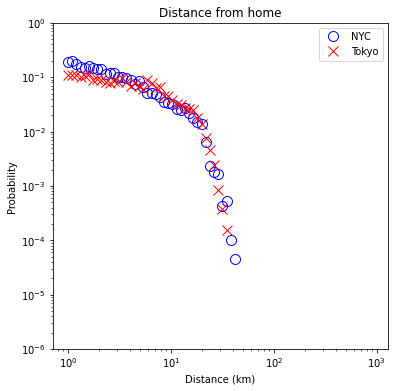

In [29]:
hist_nyc, bin_edges_nyc = np.histogram(nyc_checkin_homes['distance'], bins=np.logspace(np.log10(1),np.log10(1000.0), 75), density=True)
hist_tky, bin_edges_tky = np.histogram(tky_checkin_homes['distance'], bins=np.logspace(np.log10(1),np.log10(1000.0), 75), density=True)


plt.figure(figsize=(6,6))
plt.plot(bin_edges_nyc[:-1], hist_nyc, 'bo', bin_edges_tky[:-1], hist_tky, 'rx', mfc='none', ms=10)
plt.xscale('log')
plt.yscale('log')
plt.legend(['NYC', 'Tokyo'])
plt.title('Distance from home')
plt.xlabel('Distance (km)')
plt.ylabel('Probability')
plt.ylim([1e-6,1e0])
plt.show()

###### 3. Interpretation: comparing this distribution to that on a global scale

From the plot above, we can first notice that the probability density distribution is very similar between New York City and Tokyo, conveying that a common "city behavior".

Compared to the replication paper figure (inserted below), users living in megalopolises have a much larger probability of travelling within about 15 km of their house. As the scale of the areas (being the metropolitan areas of New York City and Tokyo), are smaller than the entire planet, we find that the distance travelled is qualitatively similar to finding from the "Friendship and Mobility" paper, but on a smaller scale. As the data set is restricted to these metropolitan areas, check-ins that could have occured outside of these areas are not known. Meaning that, if for instance a resident of New York City goes to Miami to escape the winter and checks-in to a hotel, this information would be unavailable. 

Nonetheless, we see a similar kink the graphs that indicate that people from both these cities vastly prefer to stay in their neighborhoods rather than travelling to more distant ones. In this regard, it may be that people in both cities have more opportunities to live closer to work and places where they enjoy going to in their free time. 

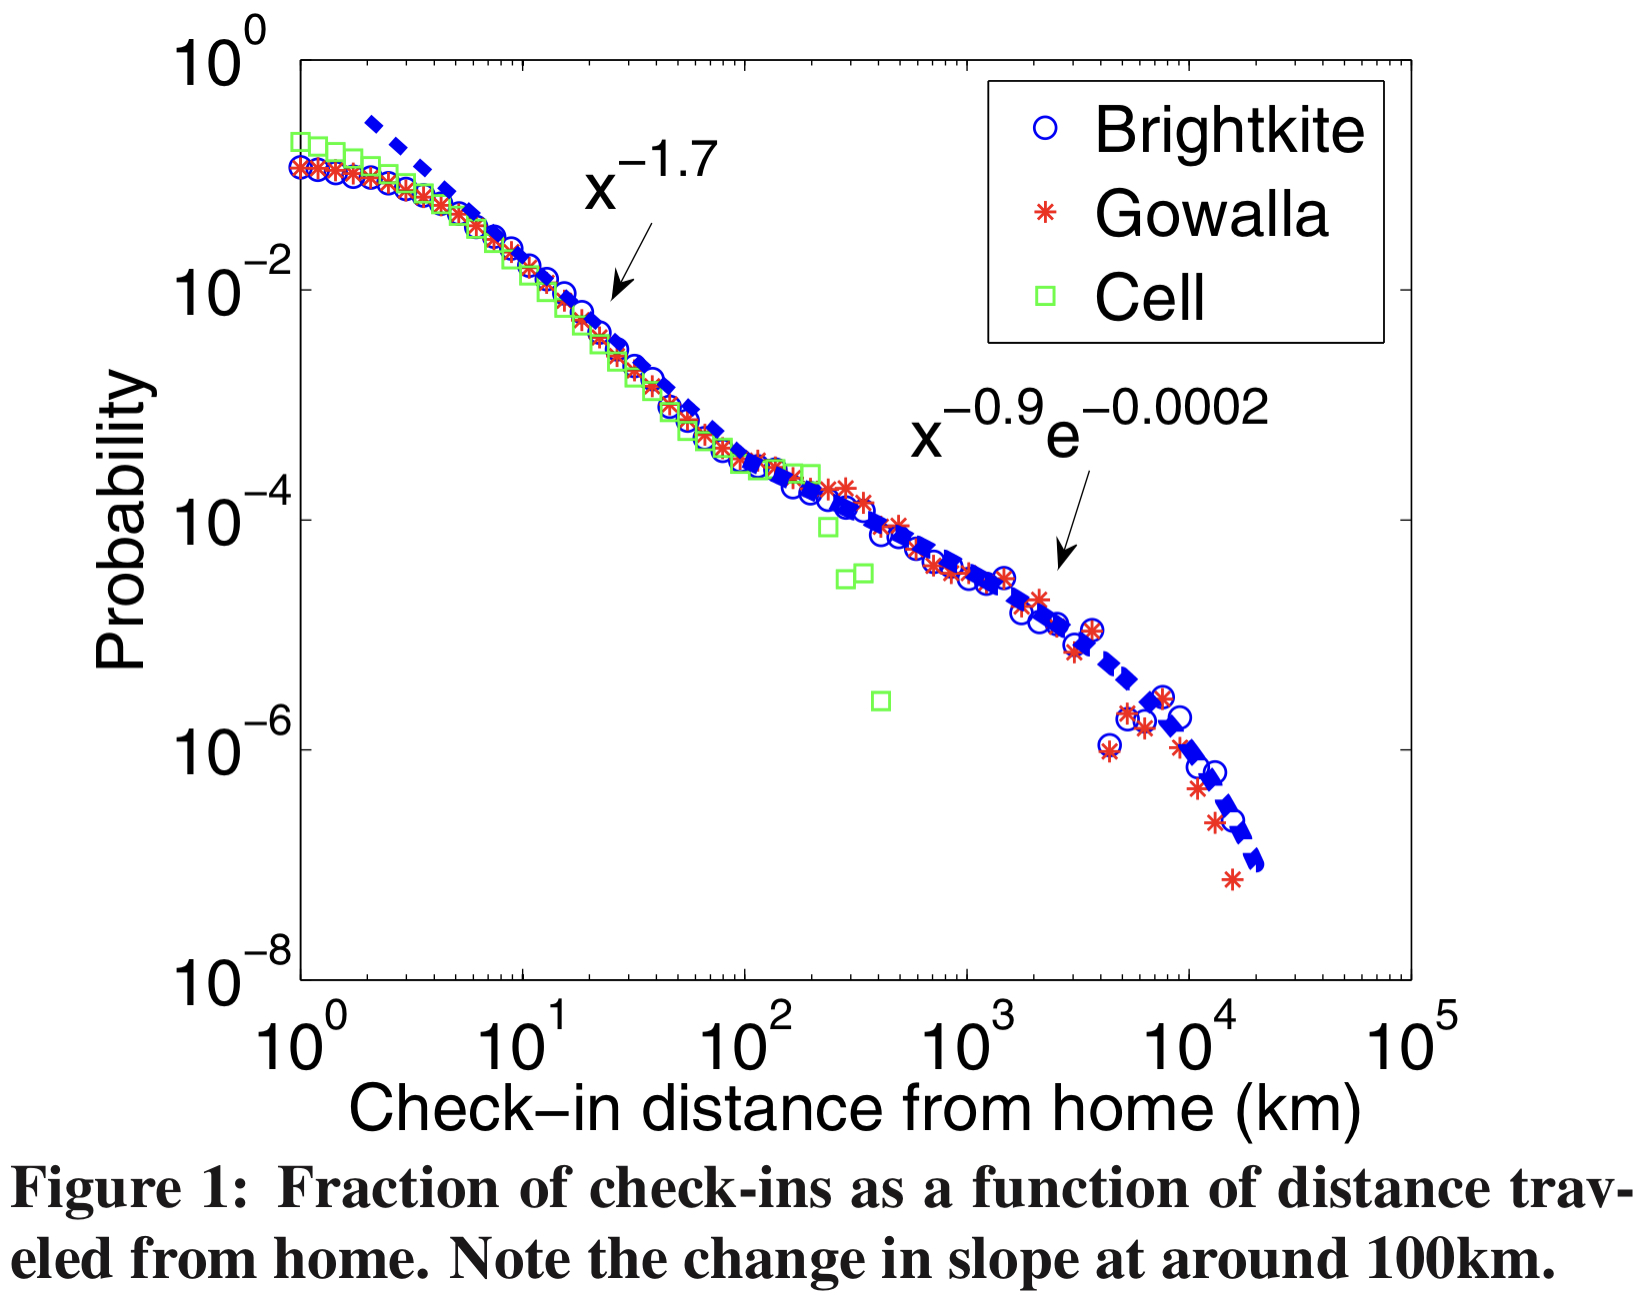

# Part 4: What are the routine and habits of individuals living in megalopolises?

Now that we have seen that individuals restrict their travel distance to locations smaller than 100 km, let's see what kind of routines they have!

### <ins>Step 1</ins>: Do users cluster in the same areas during the day?

An interesting question is to see if people tend to agglomerate to particular areas in densely populated areas. Or are they spread out over then entire megalopolis? 

###### 1. Seeing agglomeration of indivuduals in NYC

###### These can be obtained by using the maps made with Keplergl below. We include pictures here to show these distributions as they do not load when pushing to github. 

In [30]:
# Create a geopandas data frame using a sampled portion of the data 
# Sample the data to keep html file sizes smaller for the data story, pictures shown below are on the entire data set!
nyc_sampled = nyc.sample(frac=0.2)

gdf_nyc = gpd.GeoDataFrame(nyc_sampled, geometry = gpd.points_from_xy(nyc_sampled.longitude, nyc_sampled.latitude))

# Due to some limitations in handling dates by the json serializer with the keplergl library, we need to set the date of every check-in to the same date
# so that we can uniquely deal with the time of the check-in, disregarding its actual date. This allows us to see where users cluster during different
# times of the day. 

# Create a column with an arbitrary date to compare different times
gdf_nyc['time'] = gdf_nyc.local_time.apply(lambda x: x.replace(year=2020, month=12, day = 25))

# Convert columns to strings to save to html later
gdf_nyc.time = gdf_nyc.time.astype(str)
gdf_nyc.local_time = gdf_nyc.local_time.astype(str)
gdf_nyc.UTC_time = gdf_nyc.UTC_time.astype(str)

In [31]:
# Show the data using the keplergl library

# This py file loads the map configuation dictionaries; these configurations have the type of plot, colours, map zoom, etc. 
# This gives the information for both tokyo and new york so it only needs to be run once
%run kepler_configs.py

# Create the Kepler map
map_nyc = KeplerGl(height=800)

# Add the data
map_nyc.add_data(data = gdf_nyc, name = 'NYC Data')

# Set the map configuration
map_nyc.config = config_nyc

# display the map (commented out since it does not show up on github)
#map_nyc

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


<table><tr>
<td> <img src="Images/nyc_hourly_0h.png" style="width: 500px;"/>
     <br>
     <em style="color: grey">New York City check-ins between 0h-6h</em></td>
<td> <img src="Images/nyc_hourly_6h.png" style="width: 500px;"/>
     <br>
     <em style="color: grey">New York City check-ins between 6h-12h</em></td>
</tr></table>

<table><tr>
<td> <img src="Images/nyc_hourly_12h.png" style="width: 500px;"/>
     <br>
     <em style="color: grey">New York City check-ins between 12h-18h</em></td>
<td> <img src="Images/nyc_hourly_18h.png" style="width: 500px;"/>
     <br>
     <em style="color: grey">New York City check-ins between 18h-24h</em></td>
</tr></table>

In [32]:
# Save the map to html
map_nyc.save_to_html(file_name = 'NYC_hourly.html', config=config_nyc, read_only=True)

Map saved to NYC_hourly.html!


###### 2. Seeing agglomeration of individuals in Tokyo

In [33]:
# Create a geopandas data frame using a sampled portion of the data 
# Sample the data to keep html file sizes smaller for the data story, pictures shown below are on the entire data set!
tky_sampled = tky.sample(frac=0.2)

gdf_tky = gpd.GeoDataFrame(tky_sampled, geometry = gpd.points_from_xy(tky_sampled.longitude, tky_sampled.latitude))

# Due to some limitations in handling dates by the json serializer with the keplergl library, we need to set the date of every check-in to the same date
# so that we can uniquely deal with the time of the check-in, disregarding its actual date. This allows us to see where users cluster during different
# times of the day. 

# Create a column with an arbitrary date to compare different times
gdf_tky['time'] = gdf_tky.local_time.apply(lambda x: x.replace(year=2020, month=12, day = 25))

# Convert columns to strings to save to html later
gdf_tky.time = gdf_tky.time.astype(str)
gdf_tky.local_time = gdf_tky.local_time.astype(str)
gdf_tky.UTC_time = gdf_tky.UTC_time.astype(str)

In [34]:
# Create the Kepler map
map_tky = KeplerGl(height=800)

# Add the data
map_tky.add_data(data = gdf_tky, name = 'TKY Data')

# Set the map configuration
map_tky.config = config_tky

# display the map (commented out since it does not show up on github)
#map_tky

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


<table><tr>
<td> <img src="Images/tky_hourly_0h.png" style="width: 500px;"/>
     <br>
     <em style="color: grey">Tokyo check-ins between 0h-6h</em></td>
<td> <img src="Images/tky_hourly_6h.png" style="width: 500px;"/>
     <br>
     <em style="color: grey">Tokyo check-ins between 6h-12h</em></td>
</tr></table>

<table><tr>
<td> <img src="Images/tky_hourly_12h.png" style="width: 500px;"/>
     <br>
     <em style="color: grey">Tokyo check-ins between 12h-18h</em></td>
<td> <img src="Images/tky_hourly_18h.png" style="width: 500px;"/>
     <br>
     <em style="color: grey">Tokyo check-ins between 18h-24h</em></td>
</tr></table>

In [ ]:
# Save the map to html
map_tky.save_to_html(file_name = 'Tokyo_hourly.html', config=config_tky, read_only=True)

###### 3. Interpretation __NEEDS TO BE REDONE__

Some general trends are observed in both of these megalopolises: the population seems to agglomerate to the center of the cities in the morning (from 6 am - 12 pm), then in the afternoon that distribution remains the same but the density increases (from 12 pm to 6 pm).  Then, both cities see the density decrease, as people return to their homes and the activity seems to die down.

However it is important to note that given the important amount of individuals concentrated in these megalopolesis, there are still people present in all regions of these respective cities.  This could render one of the perks of living in a dense city: the cities are always buzzing with people!

### <ins>Step 2</ins>: When are the check-ins done?

Another factor to look at which could reflect the activity of users in megalopolises is the distribution of the check-ins according to time.

###### 1. Plotting the distribution of Check-ins according to time

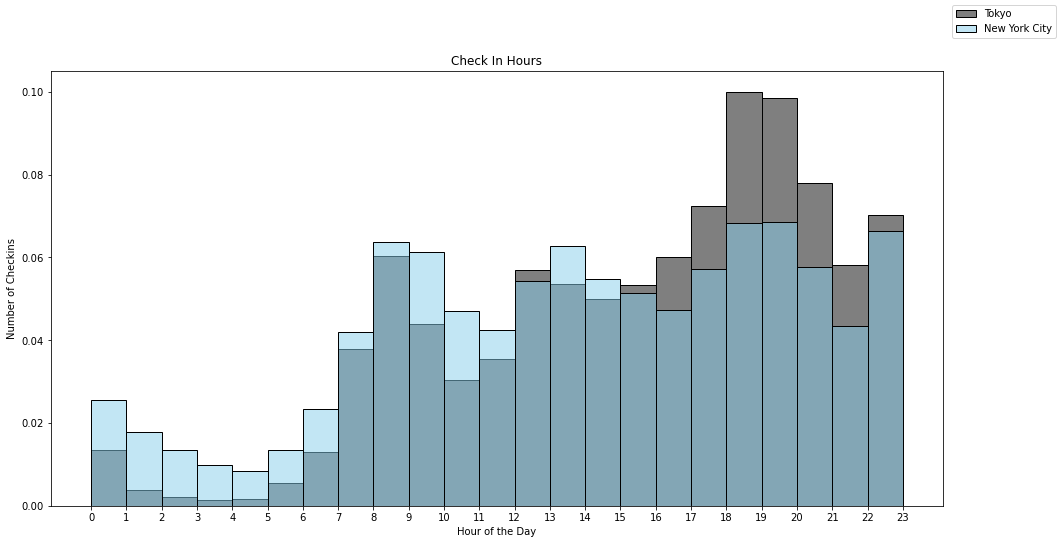

In [36]:
fig, ax = plt.subplots(figsize=(16,8))



sns.histplot(data = tky, x = tky.local_time.dt.hour, ax = ax, binwidth=1, color = 'black', alpha = 0.5,
             stat = 'probability', label = 'Tokyo')
sns.histplot(data = nyc, x = nyc.local_time.dt.hour, ax = ax, binwidth=1, color = 'skyblue', alpha = 0.5,
             stat = 'probability', label = 'New York City')
fig.legend()
ax.set(title = 'Check In Hours', xlabel='Hour of the Day', ylabel ='Number of Checkins', xticks = np.arange(0,24));

In both cities, the amount of check-ins remains relatively low in the morning and increases considerably from 8 am up to 23 pm.

It is also interesting to note that for New York City, the amount of check-in is higher in during the night (from 12 am to 7am).  On the other hand, users in Tokyo are more active in the late afternoon/evening, as the check-ins are more important from 4 pm to 10 pm).

This difference in number of check-in could reflect a more active nightlife in New York City compared to Tokyo, and a more active evening in Tokyo.  The difference of activity could be explained by the cultural differences of these two cities.

We have seen how the activity is quantitatively distributed during the day, when individuals of a city are more active and where they are located geographically. The next logical step is to see dive more into detail: what type of activities are done by these two agglomeration?

# Part 5: What are the popular activities of city-lovers?

Now that we have seen where people agglomerate during the different time period and the distribution of the activity level during the day, it is interesting to dive deeper into what type of activities they do! What are the most frequently done activities? And it is also interesting to filter them out according to different time periods: when are these activities most popular?

Something interesting to look at is also the distribution of these types of activities: are all the restaurants in the same borough? Are all the gyms in the same area?

### <ins>Step 1</ins>:  Grouping the venue types by categories

###### 1. Seeing how many types of categories there are

In [37]:
print("Number of venue types in NYC: "+str(len(nyc.venue_category_name.unique())))
print("Number of venue types in Tokyo: "+str(len(tky.venue_category_name.unique())))

Number of venue types in NYC: 251
Number of venue types in Tokyo: 247


Given that there are 251 types of venues, it would be interesting to group them into fewer categories to get a clearer idea of the different types of categories

###### 2. A first attempt at categorizing venues into categories according to topic detection in natural language processing

In [38]:
venues_nyc = list(nyc.venue_category_name.unique())
venues_tky = list(tky.venue_category_name.unique())

In [39]:
nyc_venues_dataset = [venues.split() for venues in venues_nyc]

In [40]:
dictionary_nyc = corpora.Dictionary(nyc_venues_dataset)

corpus_nyc = [dictionary_nyc.doc2bow(venue) for venue in nyc_venues_dataset]

In [41]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus_nyc, num_topics=8, id2word = dictionary_nyc, passes=50)

In [42]:
ldamodel.show_topic(1,20)

[('Store', 0.0321422),
 ('General', 0.03213497),
 ('Shop', 0.032122817),
 ('Theater', 0.021857826),
 ('Arts', 0.021854682),
 ('Center', 0.021854578),
 ('Travel', 0.02185414),
 ('Venue', 0.02185366),
 ('Video', 0.021853657),
 ('Entertainment', 0.02185364),
 ('College', 0.01223443),
 ('&', 0.012091503),
 ('Salon', 0.011569968),
 ('Game', 0.0115698865),
 ('Gym', 0.011569476),
 ('Fitness', 0.011569476),
 ('Performing', 0.01156946),
 ('Smoke', 0.011569424),
 ('Donut', 0.011569424),
 ('Bus', 0.011569424)]

Using natural language processing in order to divide venues into different topics does not seem to efficiently split them into the desired category.  Therefore, another method will be explored in order to go ahead with this categorization

###### 3. A different attempt at categorizing venues

Another efficient way that could be used to classify activities would be to see if the venues contain strings that can help identify the type of category it would best fit in. For instance, a lot of the venues related to shopping contain the word "shop", or the venues related to eating contain the string "Restaurant".

Moreover, when taking a look at the type of venues for both New York City and Tokyo, they have the same categories.

In [43]:
# Show that the number of words grouped per categories is considerable compared to the total amount of venues (to show that we are grouping enough proportion)

In [44]:
from helpers import generate_activites

Food_activities_nyc, Art_and_Entertainment_Activities_nyc, Fitness_Activities_nyc, Shopping_Activities_nyc, \
Professional_Activities_nyc, Travel_Activities_nyc, Home_Activities_nyc, Nightlife_Activities_nyc = generate_activites(nyc)


Food_activities_tky, Art_and_Entertainment_Activities_tky, Fitness_Activities_tky, Shopping_Activities_tky, \
Professional_Activities_tky, Travel_Activities_tky, Home_Activities_tky, Nightlife_Activities_tky = generate_activites(tky)

In [45]:
# Showing proportions in NYC

print('The percentage of food-related venues in NYC is: {:.2f}%.'.format(100*len(Food_activities_nyc)/len(nyc)))
print('The percentage of entertainment venus in NYC is: {:.2f}%.'.format(100*len(Art_and_Entertainment_Activities_nyc)/len(nyc)))
print('The percentage of fitness venues in NYC is: {:.2f}%.'.format(100*len(Fitness_Activities_nyc)/len(nyc)))
print('The percentage of shopping venues in NYC is: {:.2f}%.'.format(100*len(Shopping_Activities_nyc)/len(nyc)))
print('The percentage of professional venues in NYC is: {:.2f}%.'.format(100*len(Professional_Activities_nyc)/len(nyc)))
print('The percentage of travel and transportation venues in NYC is: {:.2f}%.'.format(100*len(Travel_Activities_nyc)/len(nyc)))
print('The percentage of residential venues in NYC is: {:.2f}%.'.format(100*len(Home_Activities_nyc)/len(nyc)))
print('The percentage of nightlife venues in NYC is: {:.2f}%.'.format(100*len(Nightlife_Activities_nyc)/len(nyc)))

The percentage of food-related venues in NYC is: 15.93%.
The percentage of entertainment venus in NYC is: 13.00%.
The percentage of fitness venues in NYC is: 5.63%.
The percentage of shopping venues in NYC is: 17.74%.
The percentage of professional venues in NYC is: 20.98%.
The percentage of travel and transportation venues in NYC is: 12.97%.
The percentage of residential venues in NYC is: 15.81%.
The percentage of nightlife venues in NYC is: 7.94%.


In [46]:
print('The percentage of food-related venues in Tokyo is: {:.2f}%.'.format(100*len(Food_activities_tky)/len(tky)))
print('The percentage of entertainment venus in Tokyo is: {:.2f}%.'.format(100*len(Art_and_Entertainment_Activities_tky)/len(tky)))
print('The percentage of fitness venues in Tokyo is: {:.2f}%.'.format(100*len(Fitness_Activities_tky)/len(tky)))
print('The percentage of shopping venues in Tokyo is: {:.2f}%.'.format(100*len(Shopping_Activities_tky)/len(tky)))
print('The percentage of professional venues in Tokyo is: {:.2f}%.'.format(100*len(Professional_Activities_tky)/len(tky)))
print('The percentage of travel and transportation venues in Tokyo is: {:.2f}%.'.format(100*len(Travel_Activities_tky)/len(tky)))
print('The percentage of residential venues in Tokyo is: {:.2f}%.'.format(100*len(Home_Activities_tky)/len(tky)))
print('The percentage of nightlife venues in Tokyo is: {:.2f}%.'.format(100*len(Nightlife_Activities_tky)/len(tky)))

The percentage of food-related venues in Tokyo is: 13.76%.
The percentage of entertainment venus in Tokyo is: 9.92%.
The percentage of fitness venues in Tokyo is: 1.49%.
The percentage of shopping venues in Tokyo is: 17.01%.
The percentage of professional venues in Tokyo is: 8.29%.
The percentage of travel and transportation venues in Tokyo is: 46.52%.
The percentage of residential venues in Tokyo is: 6.89%.
The percentage of nightlife venues in Tokyo is: 2.82%.


Our categories reflect a large proportion of check-ins from the original data set. However, it is possible that some venues can fit in multiple categories (such as a resto-pub, fitting in both food and nightlife). This means that the total percentage exceeds 100% of the data, but the goal of these categories is to group the data in order to see trends.

### <ins>Step 2</ins>: What are the most popular activities in densely populated cities?

The first interesting thing to look at for both cities corresponds to the most important activities done by the users: what are the most attractive activities done in these cities?

###### 1. Distribution for New York City

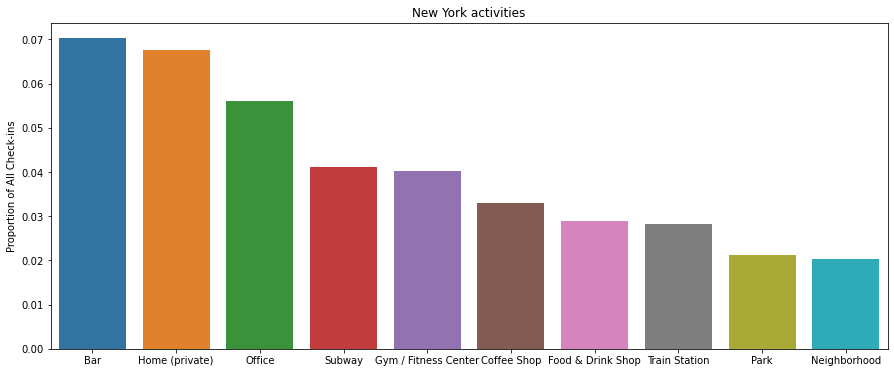

In [47]:
# What are the most popular types of venues?
nyc_pop_venues = nyc.venue_category_name.value_counts().nlargest(10);

fig, ax = plt.subplots(figsize=(15,6))
sns.barplot(x = nyc_pop_venues.keys(), y = nyc_pop_venues/len(nyc)).set(title='New York activities', ylabel ='Proportion of All Check-ins');

Interestingly enough, when looking at the distributin of the activities, there is an overwhelming amount of check-ins at the bar, followed by home check-ins, office, subway and gym.

###### 2. Distribution of activities in Tokyo

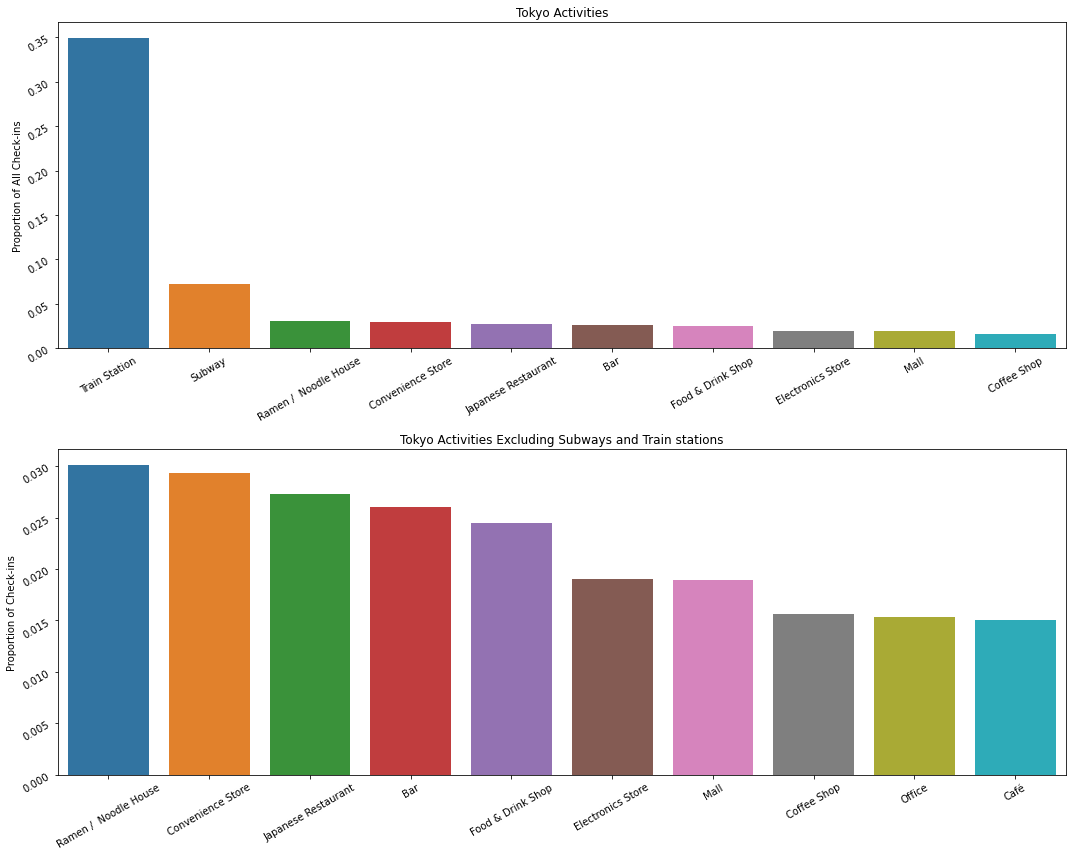

In [48]:
tky_pop_venues = tky.venue_category_name.value_counts().nlargest(10);
tky_pop_venues_secondary = tky.venue_category_name[(tky['venue_category_name'] != 'Train Station') & (tky['venue_category_name'] != 'Subway')].value_counts().nlargest(10);

fig, ax= plt.subplots(2,1, figsize=(15,12), squeeze=False)
sns.barplot(x = tky_pop_venues.keys(), y = tky_pop_venues/len(tky), ax = ax[0][0]).set(title='Tokyo Activities', ylabel ='Proportion of All Check-ins');
sns.barplot(x = tky_pop_venues_secondary.keys(), y = tky_pop_venues_secondary/len(tky)).set(title='Tokyo Activities Excluding Subways and Train stations', \
                                                                                            ylabel ='Proportion of Check-ins');
for ax in fig.axes:
    ax.tick_params(labelrotation=30)
fig.tight_layout()

Surprisingly enough, the distribution of the venue types is entirely different compared to New York City.  In fact, the Tokyoites spend an overwhelming amount of their time at the train station or in the subway!

To get an idea of the proportion of secondary check-ins, in other words those that are not "train station" or "subway", let's plot the histogram without the first two venue type.

In this second plot, we can notice that the activities with the most check-ins that are not related to transportation corresponds to either eating outside, going to the bar or the mal.  Surprisingly enough, check-ins related to "office" are ranked lower than one could expect.

### <ins>Step 3</ins>: What are the most popular activities done during different time periods of the day?

Another interesting way to look at the most popular activities is to see for different time periods which one are the most popular.  When do city-people prefer to go to the gym? to go shopping? to go to restaurants?

###### 1. Distribution for New York City

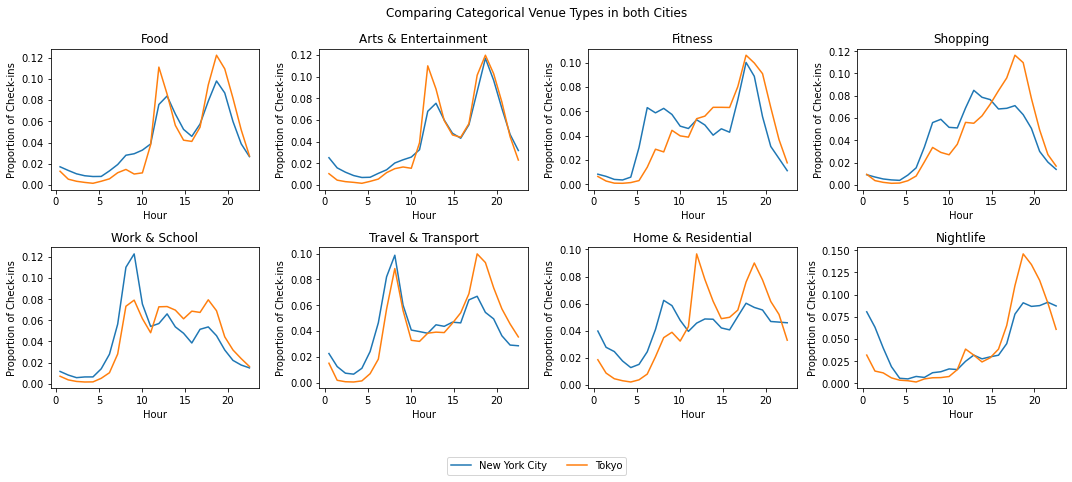

In [49]:
# Food_activities_nyc, Art_and_Entertainment_Activities_nyc, Fitness_Activities_nyc, Shopping_Activities_nyc, \
# Professional_Activities_nyc, Travel_Activities_nyc, Home_Activities_nyc, Nightlife_Activities_nyc = generate_activites(nyc)

activities_list_nyc = [Food_activities_nyc, Art_and_Entertainment_Activities_nyc, Fitness_Activities_nyc, Shopping_Activities_nyc, \
                   Professional_Activities_nyc, Travel_Activities_nyc, Home_Activities_nyc, Nightlife_Activities_nyc]

activities_list_tky = [Food_activities_tky, Art_and_Entertainment_Activities_tky, Fitness_Activities_tky, Shopping_Activities_tky, \
                   Professional_Activities_tky, Travel_Activities_tky, Home_Activities_tky, Nightlife_Activities_tky]

title_list = ['Food', 'Arts & Entertainment', 'Fitness', 'Shopping', 'Work & School', 'Travel & Transport', 'Home & Residential', 'Nightlife']

fig, ax = plt.subplots(2,4, figsize=(15,6))

idx = 0;
for i in range(2):
    for j in range(4):
        # Get midpoints from histogram to create lineplots
        data_nyc = nyc.loc[nyc.venue_category_name.isin(activities_list_nyc[idx].venue_category_name.unique())]
        data_tky = tky.loc[tky.venue_category_name.isin(activities_list_tky[idx].venue_category_name.unique())]
        
        count_nyc, bins_nyc, _ = plt.hist(data_nyc.local_time.dt.hour, bins = 24);
        count_tky, bins_tky, _ = plt.hist(data_tky.local_time.dt.hour, bins = 24)
        
        mbins_nyc = [(bins_nyc[k]+bins_nyc[k+1])/2 for k in range(len(count_nyc))]
        mbins_tky = [(bins_tky[k]+bins_tky[k+1])/2 for k in range(len(count_tky))]
        
        # Normalization
        count_nyc = count_nyc / np.sum(count_nyc)
        count_tky = count_tky / np.sum(count_tky)
        
        # Need to clear last subplot due to the way it is coded, the histograms from above show up
        ax[1,3].clear()
        ax[i, j].plot(mbins_nyc, count_nyc)
        ax[i, j].plot(mbins_tky, count_tky)
        ax[i, j].title.set_text(title_list[idx])
        ax[i, j].set(xlabel = 'Hour', ylabel = 'Proportion of Check-ins')
        idx+=1
        
fig.legend(['New York City', 'Tokyo'], loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
fig.suptitle("Comparing Categorical Venue Types in both Cities")
plt.tight_layout()



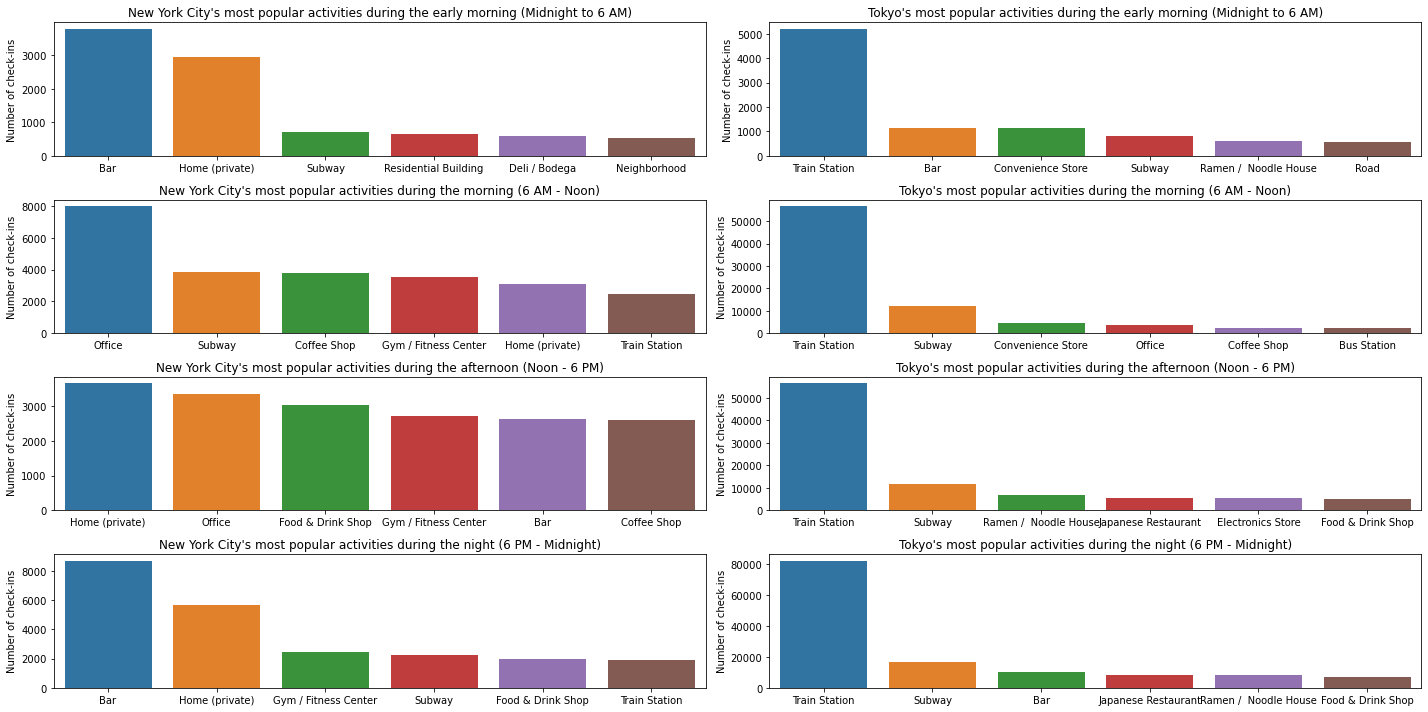

In [50]:
# Comparing the time of day and what activities are the most popular 

# Set up plotting variables (hour start and hour end)
h_start = [0, 6, 12, 18]; h_end = [6, 12, 18, 24]
titles = ["{}'s most popular activities during the early morning (Midnight to 6 AM)",
          "{}'s most popular activities during the morning (6 AM - Noon)",
          "{}'s most popular activities during the afternoon (Noon - 6 PM)",
          "{}'s most popular activities during the night (6 PM - Midnight)"]



fig, ax = plt.subplots(4,2, figsize=(20,10))
for i in range(4):
       
        # Get the most popular venues for the given time range
        time_period_considered = np.arange(h_start[i], h_end[i])
        nyc_pop_venues = nyc.loc[nyc.local_time.dt.hour.isin(time_period_considered)]["venue_category_name"].value_counts().nlargest(6)
        #nyc_pop_venues.replace({'Residential Building (Apartment / Condo)' : 'Residential Building'}, regex = True)
        tky_pop_venues = tky.loc[tky.local_time.dt.hour.isin(time_period_considered)]["venue_category_name"].value_counts().nlargest(6)
        
        # Create a bar plot showing the most popular activities
        
        # New York 
        # Rename a column to avoid names overlapping
        nyc_pop_venues = nyc_pop_venues.rename({'Residential Building (Apartment / Condo)' : 'Residential Building'})
        sns.barplot(x = nyc_pop_venues.keys(), y = nyc_pop_venues, ax = ax[i][0]).set(title=titles[i].format('New York City'))
        ax[i][0].set_ylabel('Number of check-ins')
        
        # Tokyo
        sns.barplot(x = tky_pop_venues.keys(), y = tky_pop_venues, ax = ax[i][1]).set(title=titles[i].format('Tokyo'))
        ax[i][1].set_ylabel('Number of check-ins')
        
fig.tight_layout()

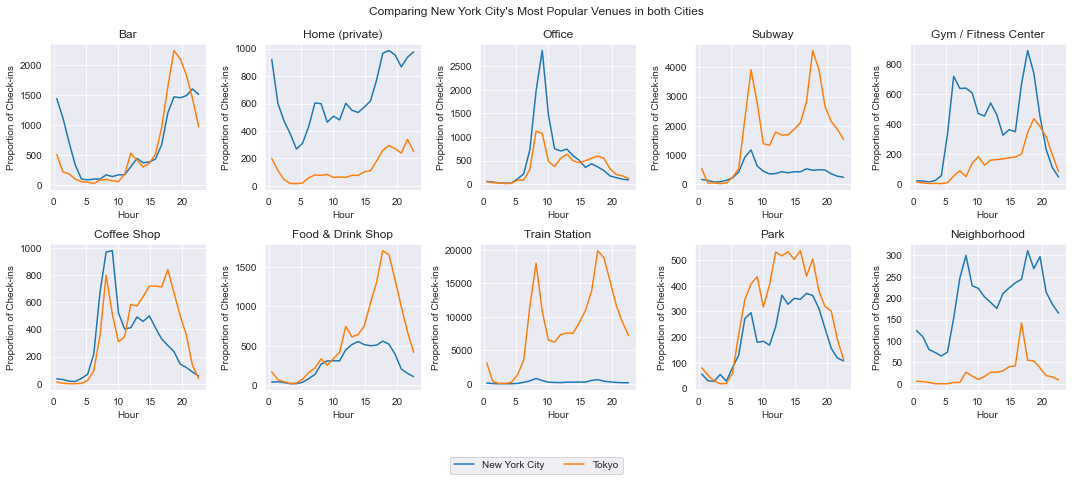

In [51]:
# Creating distribution map for top 10 most popular NYC activities
# Creating plot
sns.set_style(style="darkgrid")

fig, ax = plt.subplots(2,5, figsize=(15,6))

nyc_pop_venues = nyc.venue_category_name.value_counts().nlargest(10);

idx = 0;
for i in range(2):
    for j in range(5):
        # Get midpoints from histogram to create lineplots
        count_nyc, bins_nyc, _ = plt.hist(nyc.loc[nyc.venue_category_name == nyc_pop_venues.keys()[idx]].local_time.dt.hour, bins = 24);
        count_tky, bins_tky, _ = plt.hist(tky.loc[tky.venue_category_name == nyc_pop_venues.keys()[idx]].local_time.dt.hour, bins = 24);
        
        mbins_nyc = [(bins_nyc[k]+bins_nyc[k+1])/2 for k in range(len(count_nyc))]
        mbins_tky = [(bins_tky[k]+bins_tky[k+1])/2 for k in range(len(count_tky))]
        
        # Normalization
#         count_nyc = count_nyc / np.sum(count_nyc)
#         count_tky = count_tky / np.sum(count_tky)
        
        # Need to clear last subplot due to the way it is coded, the histograms from above show up
        ax[1,4].clear()
        ax[i, j].plot(mbins_nyc, count_nyc)
        ax[i, j].plot(mbins_tky, count_tky)
        ax[i, j].title.set_text(nyc_pop_venues.keys()[idx])
        ax[i, j].set(xlabel = 'Hour', ylabel = 'Proportion of Check-ins')
        idx+=1
        
fig.legend(['New York City', 'Tokyo'], loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
fig.suptitle("Comparing New York City's Most Popular Venues in both Cities")
plt.tight_layout()


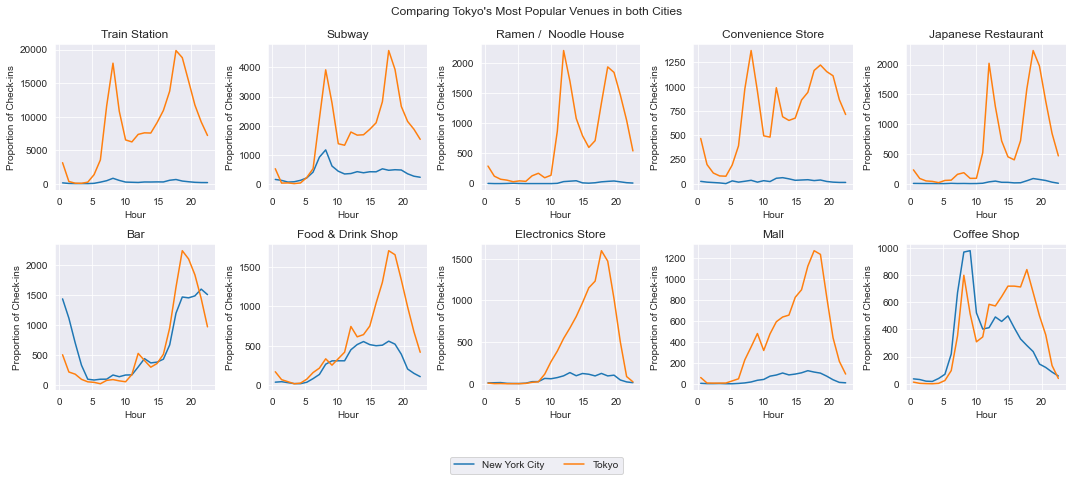

In [52]:
# Creating distribution map for top 10 most popular NYC activities
# Creating plot
sns.set_style(style="darkgrid")

fig, ax = plt.subplots(2,5, figsize=(15,6))

tky_pop_venues = tky.venue_category_name.value_counts().nlargest(10);

idx = 0;
for i in range(2):
    for j in range(5):
        # Get midpoints from histogram to create lineplots
        count_nyc, bins_nyc, _ = plt.hist(nyc.loc[nyc.venue_category_name == tky_pop_venues.keys()[idx]].local_time.dt.hour, bins = 24);
        count_tky, bins_tky, _ = plt.hist(tky.loc[tky.venue_category_name == tky_pop_venues.keys()[idx]].local_time.dt.hour, bins = 24);
        
        mbins_nyc = [(bins_nyc[k]+bins_nyc[k+1])/2 for k in range(len(count_nyc))]
        mbins_tky = [(bins_tky[k]+bins_tky[k+1])/2 for k in range(len(count_tky))]
        
        # Normalization
#         count_nyc = count_nyc / np.sum(count_nyc)
#         count_tky = count_tky / np.sum(count_tky)
        
        # Need to clear last subplot due to the way it is coded, the histograms from above show up
        ax[1,4].clear()
        ax[i, j].plot(mbins_nyc, count_nyc)
        ax[i, j].plot(mbins_tky, count_tky)
        ax[i, j].title.set_text(tky_pop_venues.keys()[idx])
        ax[i, j].set(xlabel = 'Hour', ylabel = 'Proportion of Check-ins')
        idx+=1
        
fig.legend(['New York City', 'Tokyo'], loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
fig.suptitle("Comparing Tokyo's Most Popular Venues in both Cities")
plt.tight_layout()


### <ins>Step 4</ins>: Another way to visualize the distribution of the various activities


__A BIT UNCLEAR HOW THIS IS DIFFERENT FROM THE PREVIOUS SECTION__

Another interesting way to look at the diversity of the activities and when they are most done done by users in New York City and Tokyo respectively, is to plot the distribution of check-ins grouped by topics according to time.

Moreover, it could be interesting to see where all of these types of venues are located, are they all clustered together? Or are they spread out all over the city?

In [53]:
# Using Kepler GL we can show the daily trend of the data for our different categories!
def prep_for_kepler(df, cat_name):
    # This functions preps a dataframe to be plotted with kepler
   
    # Convert data frame to GeoPandas
    gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.longitude, df.latitude))
    
     # Add the category name to all rows 
    gdf['category'] = cat_name
    
    # Create a column with an arbitrary date to compare different times
    gdf['time'] = gdf.local_time.apply(lambda x: x.replace(year=2020, month=12, day = 25))
    
    # Change the datetimes to strings to save to html
    gdf.time = gdf.time.astype(str)
    gdf.local_time = gdf.local_time.astype(str)
    gdf.UTC_time = gdf.UTC_time.astype(str)
    
    # Return a fraction of the data for faster speeds (should not impact any distributions)
    return gdf.sample(frac=0.15)



# Set up the data in a way that it works with this library
gdf_food_nyc = prep_for_kepler(Food_activities_nyc, 'Food')
gdf_Entertainment_nyc = prep_for_kepler(Art_and_Entertainment_Activities_nyc, 'Arts & Entertainment')
gdf_Fitness_nyc = prep_for_kepler(Fitness_Activities_nyc, 'Fitness')
gdf_Shopping_nyc = prep_for_kepler(Shopping_Activities_nyc, 'Shopping')
gdf_Professional_nyc = prep_for_kepler(Professional_Activities_nyc, 'Work & School')
gdf_Transport_nyc = prep_for_kepler(Travel_Activities_nyc, 'Travel & Transport')
gdf_Home_nyc = prep_for_kepler(Home_Activities_nyc, 'Home & Residential')
gdf_Nightlife_nyc = prep_for_kepler(Nightlife_Activities_nyc, 'Nightlife')

In [54]:
# Create the Kepler map
map_nyc = KeplerGl(height=800)

# Add the data separately (for easier visualization)
map_nyc.add_data(data = gdf_food_nyc, name = 'Food')
map_nyc.add_data(data = gdf_Entertainment_nyc, name = 'Arts & Entertainment')
map_nyc.add_data(data = gdf_Fitness_nyc, name = 'Fitness')
map_nyc.add_data(data = gdf_Shopping_nyc, name = 'Shopping')
map_nyc.add_data(data = gdf_Professional_nyc, name = 'Work & School')
map_nyc.add_data(data = gdf_Transport_nyc, name = 'Travel & Transport')
map_nyc.add_data(data = gdf_Home_nyc, name = 'Home & Residential')
map_nyc.add_data(data = gdf_Nightlife_nyc, name = 'Nightlife')


map_nyc.config = nyc_categories_config
# Commented out because it does not show up on github
#map_nyc


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


<table><tr>
<td> <img src="Images/nyc_cat_food.png" style="width: 400px;"/>
     <br>
     <em style="color: grey">New York City Food Venue Locations</em></td>
<td> <img src="Images/nyc_cat_art.png" style="width: 400px;"/>
     <br>
     <em style="color: grey">New York City Art and Entertainment Venue Locations</em></td>
</tr></table>

<table><tr>
<td> <img src="Images/nyc_cat_fitness.png" style="width: 400px;"/>
     <br>
     <em style="color: grey">New York City Fitness Venue Locations</em></td>
<td> <img src="Images/nyc_cat_shopping.png" style="width: 400px;"/>
     <br>
     <em style="color: grey">New York City Shopping Venue Locations</em></td>
</tr></table>

<table><tr>
<td> <img src="Images/nyc_cat_work.png" style="width: 400px;"/>
     <br>
     <em style="color: grey">New York City Work and Education Venue Locations</em></td>
<td> <img src="Images/nyc_cat_travel.png" style="width: 400px;"/>
     <br>
     <em style="color: grey">New York City Travel and Transportation Venue Locations</em></td>
</tr></table>

<table><tr>
<td> <img src="Images/nyc_cat_home.png" style="width: 400px;"/>
     <br>
     <em style="color: grey">New York City Home and Residential Venue Locations</em></td>
<td> <img src="Images/nyc_cat_nightlife.png" style="width: 400px;"/>
     <br>
     <em style="color: grey">New York City Nightlife Venue Locations</em></td>
</tr></table>

In [55]:
# Save to html
map_nyc.save_to_html(file_name = 'NYC_categorical.html', config=nyc_categories_config, read_only=True)

Map saved to NYC_categorical.html!


In [56]:
# Set up the data in a way that it works with this library
gdf_food_tky = prep_for_kepler(Food_activities_tky, 'Food')
gdf_Entertainment_tky = prep_for_kepler(Art_and_Entertainment_Activities_tky, 'Arts & Entertainment')
gdf_Fitness_tky = prep_for_kepler(Fitness_Activities_tky, 'Fitness')
gdf_Shopping_tky = prep_for_kepler(Shopping_Activities_tky, 'Shopping')
gdf_Professional_tky = prep_for_kepler(Professional_Activities_tky, 'Work & School')
gdf_Transport_tky = prep_for_kepler(Travel_Activities_tky, 'Travel & Transport')
gdf_Home_tky = prep_for_kepler(Home_Activities_tky, 'Home & Residential')
gdf_Nightlife_tky = prep_for_kepler(Nightlife_Activities_tky, 'Nightlife')

In [57]:
# Create the Kepler map
map_tky = KeplerGl(height=800)

# Add the data separately (for easier visualization)
map_tky.add_data(data = gdf_food_tky, name = 'Food')
map_tky.add_data(data = gdf_Entertainment_tky, name = 'Arts & Entertainment')
map_tky.add_data(data = gdf_Fitness_tky, name = 'Fitness')
map_tky.add_data(data = gdf_Shopping_tky, name = 'Shopping')
map_tky.add_data(data = gdf_Professional_tky, name = 'Work & School')
map_tky.add_data(data = gdf_Transport_tky, name = 'Travel & Transport')
map_tky.add_data(data = gdf_Home_tky, name = 'Home & Residential')
map_tky.add_data(data = gdf_Nightlife_tky, name = 'Nightlife')


map_tky.config = tky_categories_config
# Commented out map because it does not appear on github
#map_tky


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


<table><tr>
<td> <img src="Images/tky_cat_food.png" style="width: 400px;"/>
     <br>
     <em style="color: grey">Tokyo Food Venue Locations</em></td>
<td> <img src="Images/tky_cat_art.png" style="width: 400px;"/>
     <br>
     <em style="color: grey">Tokyo Art and Entertainment Venue Locations</em></td>
</tr></table>

<table><tr>
<td> <img src="Images/tky_cat_fitness.png" style="width: 400px;"/>
     <br>
     <em style="color: grey">Tokyo Fitness Venue Locations</em></td>
<td> <img src="Images/tky_cat_shopping.png" style="width: 400px;"/>
     <br>
     <em style="color: grey">Tokyo Shopping Venue Locations</em></td>
</tr></table>

<table><tr>
<td> <img src="Images/tky_cat_work.png" style="width: 400px;"/>
     <br>
     <em style="color: grey">Tokyo Work and Education Venue Locations</em></td>
<td> <img src="Images/tky_cat_travel.png" style="width: 400px;"/>
     <br>
     <em style="color: grey">Tokyo Travel and Transportation Venue Locations</em></td>
</tr></table>

<table><tr>
<td> <img src="Images/tky_cat_home.png" style="width: 400px;"/>
     <br>
     <em style="color: grey">Tokyo Home and Residential Venue Locations</em></td>
<td> <img src="Images/tky_cat_nightlife.png" style="width: 400px;"/>
     <br>
     <em style="color: grey">Tokyo Nightlife Venue Locations</em></td>
</tr></table>

In [58]:
# Save to html
map_tky.save_to_html(file_name = 'TKY_categorical.html', config=tky_categories_config, read_only=True)

Map saved to TKY_categorical.html!


###### 1. Distribution of Food-Related Venues

In [60]:
# fig, ax = plt.subplots(figsize=(16,8))

# sns.histplot(data = Food_activities_nyc, x = Food_activities_nyc.local_time.dt.hour, ax = ax, binwidth=1, color = 'blue', alpha = 0.6,
#              stat = 'probability', label = 'New York City')

# sns.histplot(data = Food_activities_tky, x = Food_activities_tky.local_time.dt.hour, ax = ax, binwidth=1, color = 'orange', alpha = 0.6,
#              stat = 'probability', label = 'Tokyo')
# fig.legend()
# ax.set(title = 'Check Into Food-related venues', xlabel='Hour of the Day', ylabel ='Number of Checkins in Food-related venues', xticks = np.arange(0,24));


In [ ]:
# # Where are these venues located?

# map_nyc = folium.Map(nyc_coordinates, zoom_start=11)

# # convert to (n, 2) nd-array format for heatmap
# heatmap_locs = Food_activities_nyc[['latitude', 'longitude']].to_numpy() # Creating heatmap

# # plotting the heatmap
# map_nyc.add_child(plugins.HeatMap(heatmap_locs, radius=10))
# map_nyc

In [ ]:
# # Where are these venues located?

# map_tky = folium.Map(tky_coordinates, zoom_start=11)

# # convert to (n, 2) nd-array format for heatmap
# heatmap_locs = Food_activities_tky[['latitude', 'longitude']].to_numpy() # Creating heatmap

# # plotting the heatmap
# map_tky.add_child(plugins.HeatMap(heatmap_locs, radius=10))
# map_tky

###### 2. Distribution for Art and Entertainment-related activities

In [ ]:
# fig, ax = plt.subplots(figsize=(16,8))

# sns.histplot(data = Art_and_Entertainment_Activities_nyc, x = Art_and_Entertainment_Activities_nyc.local_time.dt.hour, ax = ax, binwidth=1, color = 'blue', alpha = 0.6,
#              stat = 'probability', label = 'New York City')

# sns.histplot(data = Art_and_Entertainment_Activities_tky, x = Art_and_Entertainment_Activities_tky.local_time.dt.hour, ax = ax, binwidth=1, color = 'orange', alpha = 0.6,
#              stat = 'probability', label = 'Tokyo')
# fig.legend()
# ax.set(title = 'Check Into Art and Entertainmment related venues', xlabel='Hour of the Day', ylabel ='Number of Checkins in Food-related venues', xticks = np.arange(0,24));


In [ ]:
# # Where are these venues located?

# map_nyc = folium.Map(nyc_coordinates, zoom_start=11)

# # convert to (n, 2) nd-array format for heatmap
# heatmap_locs = Art_and_Entertainment_Activities_nyc[['latitude', 'longitude']].to_numpy() # Creating heatmap

# # plotting the heatmap
# map_nyc.add_child(plugins.HeatMap(heatmap_locs, radius=10))
# map_nyc

###### 3. Distribution for Fitness venues

In [ ]:
# fig, ax = plt.subplots(figsize=(16,8))

# sns.histplot(data = Fitness_Activities_nyc, x = Fitness_Activities_nyc.local_time.dt.hour, ax = ax, binwidth=1, color = 'blue', alpha = 0.6,
#              stat = 'probability', label = 'New York City')

# sns.histplot(data = Fitness_Activities_tky, x = Fitness_Activities_tky.local_time.dt.hour, ax = ax, binwidth=1, color = 'orange', alpha = 0.6,
#              stat = 'probability', label = 'Tokyo')
# fig.legend()
# ax.set(title = 'Check Into Fitness-related venues', xlabel='Hour of the Day', ylabel ='Number of Checkins in Food-related venues', xticks = np.arange(0,24));


###### 4. Distribution for Shopping Venues

In [ ]:
# fig, ax = plt.subplots(figsize=(16,8))

# sns.histplot(data = Shopping_Activities_nyc, x = Shopping_Activities_nyc.local_time.dt.hour, ax = ax, binwidth=1, color = 'blue', alpha = 0.6,
#              stat = 'probability', label = 'New York City')

# sns.histplot(data = Shopping_Activities_tky, x = Shopping_Activities_tky.local_time.dt.hour, ax = ax, binwidth=1, color = 'orange', alpha = 0.6,
#              stat = 'probability', label = 'Tokyo')
# fig.legend()
# ax.set(title = 'Check Into Shopping-related venues', xlabel='Hour of the Day', ylabel ='Number of Checkins in Food-related venues', xticks = np.arange(0,24));


###### 5. Distribution of Professional Activities

In [ ]:
# fig, ax = plt.subplots(figsize=(16,8))

# sns.histplot(data = Professional_Activities_nyc, x = Professional_Activities_nyc.local_time.dt.hour, ax = ax, binwidth=1, color = 'blue', alpha = 0.6,
#              stat = 'probability', label = 'New York City')

# sns.histplot(data = Professional_Activities_tky, x = Professional_Activities_tky.local_time.dt.hour, ax = ax, binwidth=1, color = 'orange', alpha = 0.6,
#              stat = 'probability', label = 'Tokyo')
# fig.legend()
# ax.set(title = 'Check Into Professional-related venues', xlabel='Hour of the Day', ylabel ='Number of Checkins in Food-related venues', xticks = np.arange(0,24));


###### 6. Distribution of Travel/Transportation-related Activities

In [ ]:
# fig, ax = plt.subplots(figsize=(16,8))

# sns.histplot(data = Travel_Activities_nyc, x = Travel_Activities_nyc.local_time.dt.hour, ax = ax, binwidth=1, color = 'blue', alpha = 0.6,
#              stat = 'probability', label = 'New York City')

# sns.histplot(data = Travel_Activities_tky, x = Travel_Activities_tky.local_time.dt.hour, ax = ax, binwidth=1, color = 'orange', alpha = 0.6,
#              stat = 'probability', label = 'Tokyo')
# fig.legend()
# ax.set(title = 'Check Into Travel/Transportation-related venues', xlabel='Hour of the Day', ylabel ='Number of Checkins in Food-related venues', xticks = np.arange(0,24));


###### 7. Distribution for Home-related activities

In [ ]:
# fig, ax = plt.subplots(figsize=(16,8))

# sns.histplot(data = Home_Activities_nyc, x = Home_Activities_nyc.local_time.dt.hour, ax = ax, binwidth=1, color = 'blue', alpha = 0.6,
#              stat = 'probability', label = 'New York City')

# sns.histplot(data = Home_Activities_tky, x = Home_Activities_tky.local_time.dt.hour, ax = ax, binwidth=1, color = 'orange', alpha = 0.6,
#              stat = 'probability', label = 'Tokyo')
# fig.legend()
# ax.set(title = 'Check Into Home-related venues', xlabel='Hour of the Day', ylabel ='Number of Checkins in Food-related venues', xticks = np.arange(0,24));


###### 8. Distribution for Travel & Transport Activities

In [ ]:
# fig, ax = plt.subplots(figsize=(16,8))

# sns.histplot(data = Nightlife_Activities_nyc, x = Nightlife_Activities_nyc.local_time.dt.hour, ax = ax, binwidth=1, color = 'blue', alpha = 0.6,
#              stat = 'probability', label = 'New York City')

# sns.histplot(data = Nightlife_Activities_tky, x = Nightlife_Activities_tky.local_time.dt.hour, ax = ax, binwidth=1, color = 'orange', alpha = 0.6,
#              stat = 'probability', label = 'Tokyo')
# fig.legend()
# ax.set(title = 'Check Into Nightlife-related venues', xlabel='Hour of the Day', ylabel ='Number of Checkins in Food-related venues', xticks = np.arange(0,24));


In [ ]:
# Make a conclusion about the trends for the different activities, when are they most popular? When are they not?

# Part 6: Are the trends between users in New York City and Tokyo comparable?

Given the numerous questions we have studied in teh previous parts, let's conclude by looking at the trends between these two megalopolises and answer some key questions.

Are behaviors in megalopolises comparable or not? Do activities differ from these two cities due to cultural differences or can we draw some similarities?